In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import entropy
from statsmodels.nonparametric.smoothers_lowess import lowess
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D 
from adjustText import adjust_text

In [7]:
df = pd.read_csv("df_final.csv", parse_dates=["DATA"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   LOCALITA'                      468 non-null    object        
 1   STAZIONE                       468 non-null    object        
 2   STATO                          468 non-null    object        
 3   DATA                           468 non-null    datetime64[ns]
 4   ANNO                           468 non-null    int64         
 5   MESE                           468 non-null    int64         
 6   LATITUDINE                     468 non-null    float64       
 7   LONGITUDINE                    468 non-null    float64       
 8   altezza onda                   430 non-null    float64       
 9   Ammonio (µM-N)                 405 non-null    float64       
 10  Copertura cielo (decimi)       430 non-null    float64       
 11  direzione vento    

In [8]:
# definisco le variabili ambientali, chimico-fisiche
env_variables = [
    "Temperatura (°C)",
    "Salinità (PSU)",
    "Nitrati (µM-N)",
    "Nitriti (µM-N)",
    "Ossigeno disciolto (% sat.)",
    "Ammonio (µM-N)",
    "Fosfati (µM-P)",
    "Temperatura aria (°C)",
    "Copertura cielo (decimi)",
    "Intensità vento (m/s)",
    "pH",
    "altezza onda",
    "direzione vento",
]

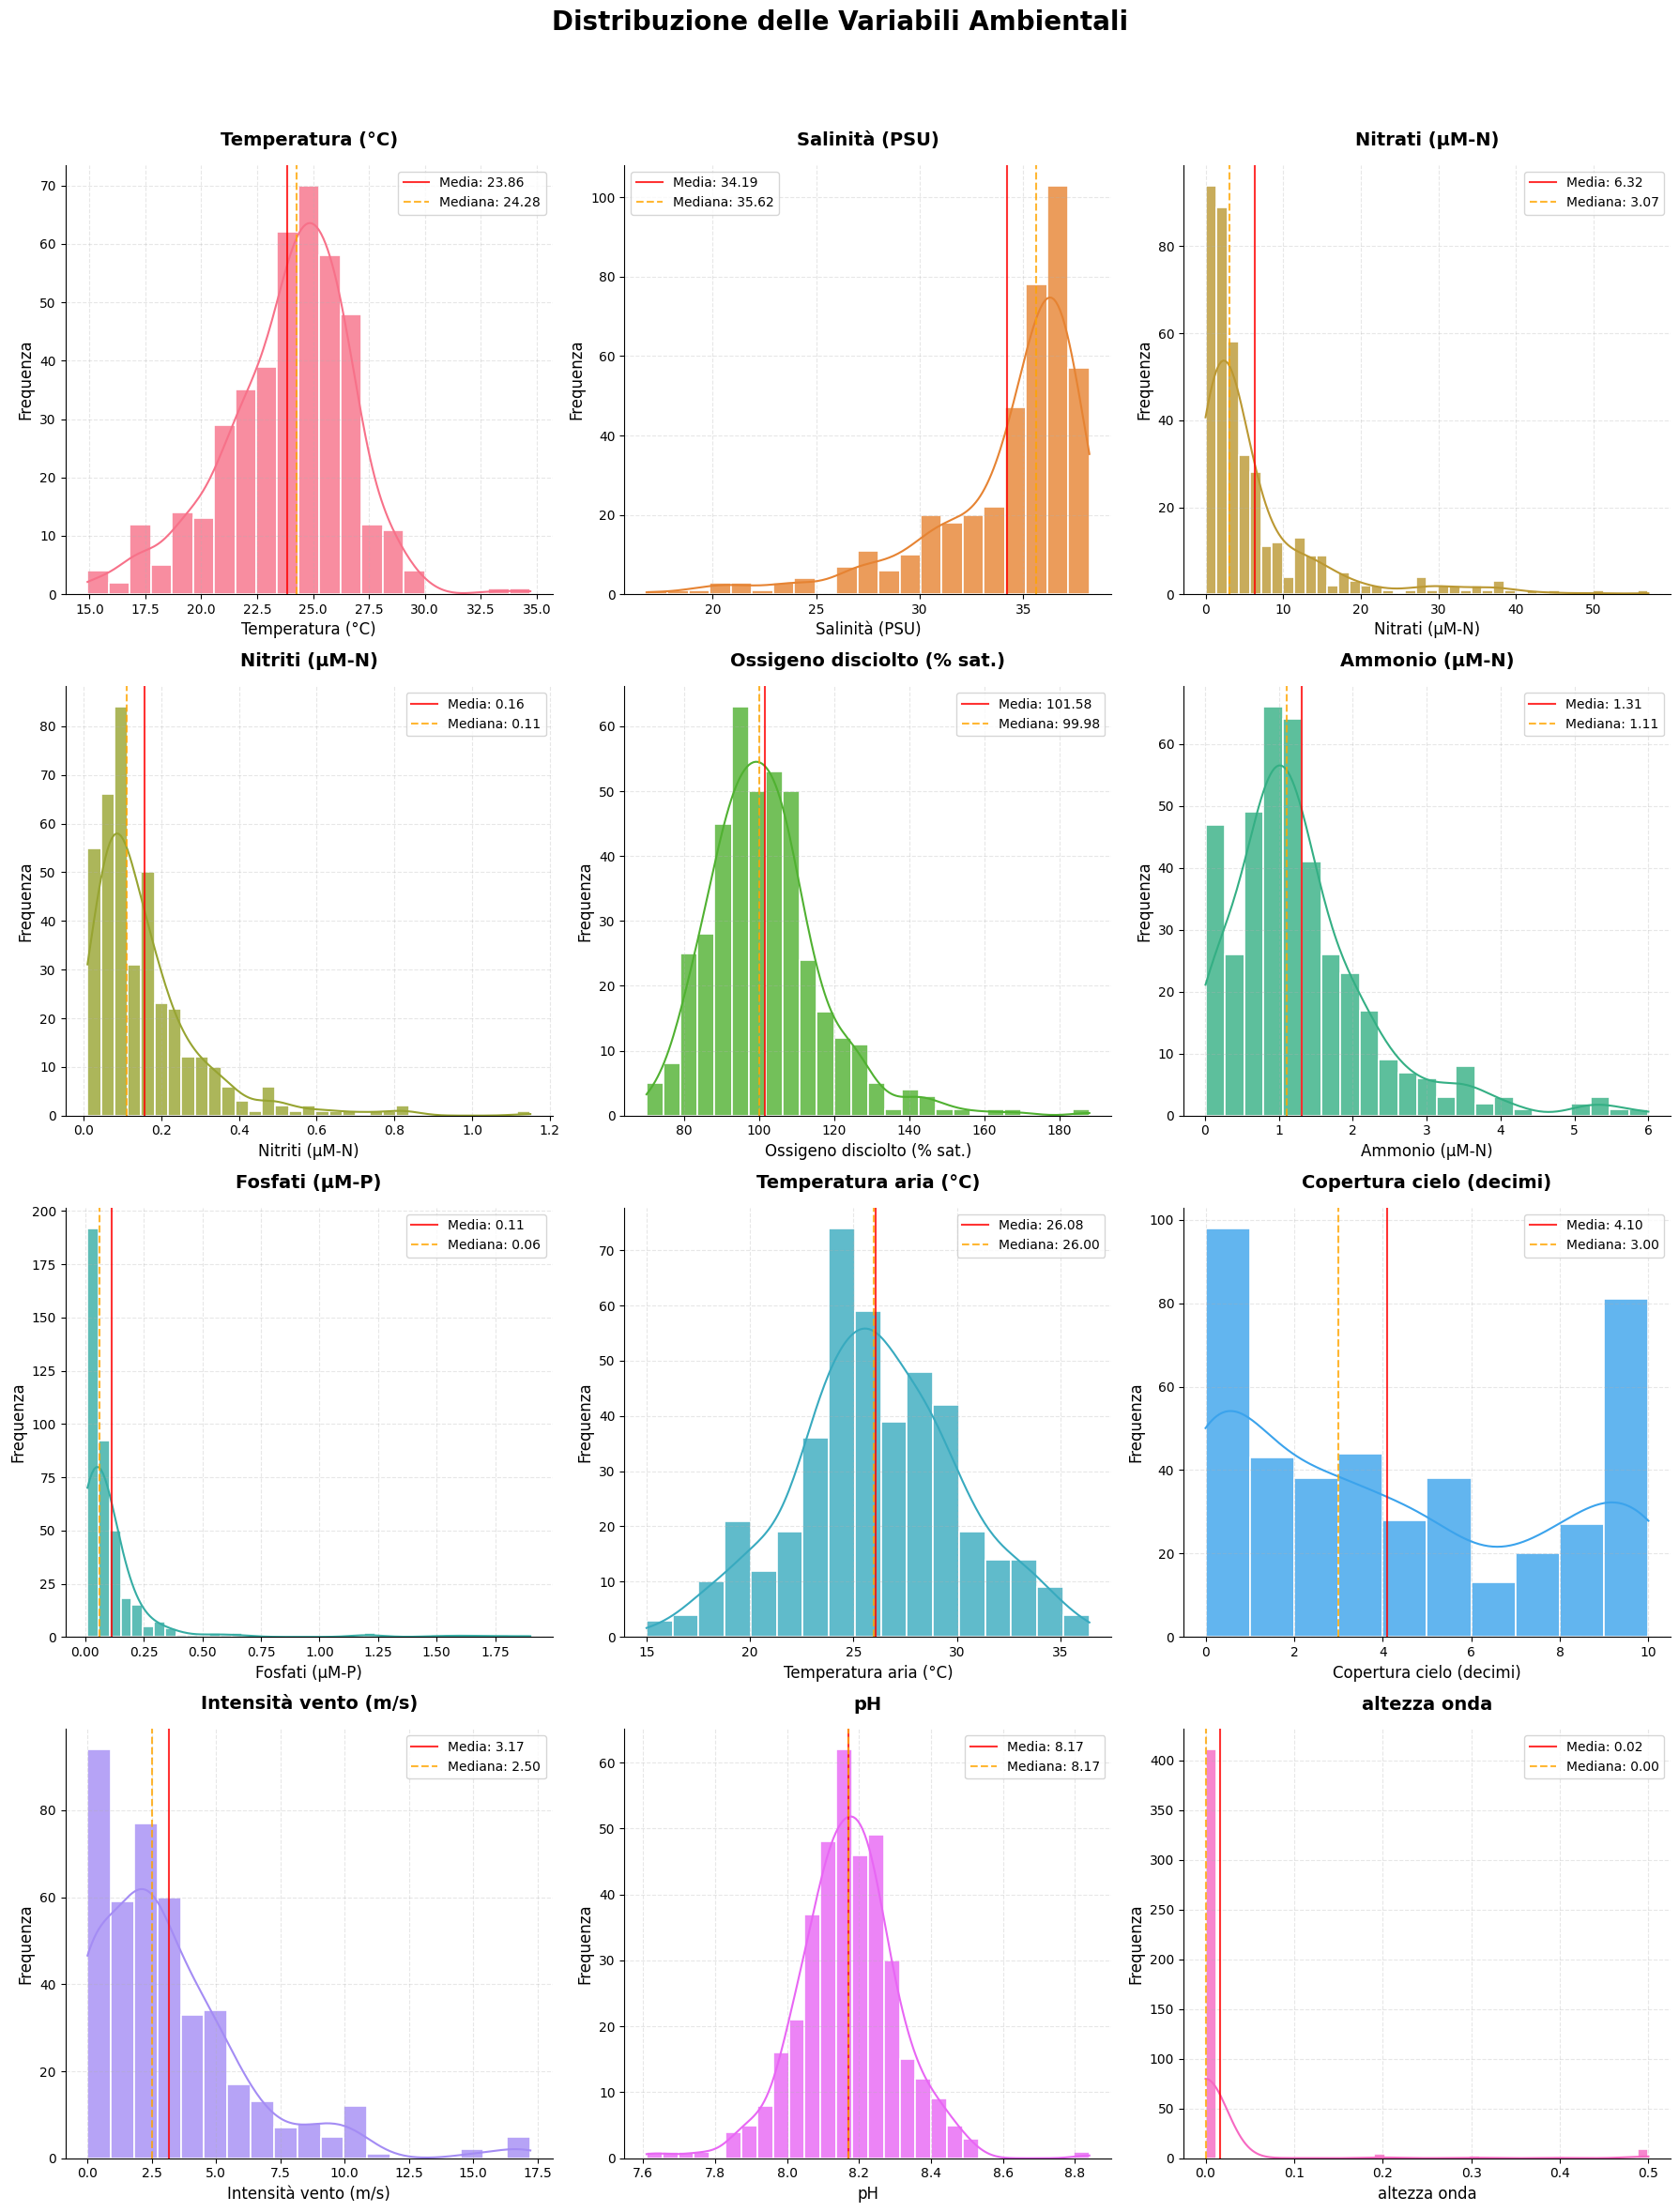

In [9]:
# filtro solo variabili numeriche (quindi tutte tranne direzione vento)
numeric_vars = [var for var in env_variables if var not in ["direzione vento"]]

# creo dimensioni griglia
n_vars = len(numeric_vars)
n_cols = 3  # 3 colonne per riga
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
fig.suptitle(
    "Distribuzione delle Variabili Ambientali", fontsize=20, fontweight="bold", y=0.98
)

# se abbiamo più di una riga
if n_rows > 1:
    axes = axes.flatten()
elif n_cols == 1:
    axes = [axes]

# palette di colori
colors = sns.color_palette("husl", n_vars)

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    # creazione istogramma con KDE
    sns.histplot(
        data=df,
        x=var,
        kde=True,
        ax=ax,
        color=colors[i],
        alpha=0.8,
        edgecolor="white",
        linewidth=1.2,
    )

    ax.set_title(f"{var}", fontsize=14, fontweight="bold", pad=15)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel("Frequenza", fontsize=12)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Aggiungi statistiche di base
    mean_val = df[var].mean()
    median_val = df[var].median()
    ax.axvline(mean_val, color="red", alpha=0.8, label=f"Media: {mean_val:.2f}")
    ax.axvline(
        median_val,
        color="orange",
        linestyle="--",
        alpha=0.8,
        label=f"Mediana: {median_val:.2f}",
    )
    ax.legend(fontsize=10)

# rimuovi subplot vuoti nel caso
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # così non si sovrappongono i titoli
plt.show()




In [10]:
# colonne con abbondanze algali cell/g e cell/l
algae_bentonic = [
    "Amphidinium carterae cell/gr",
    "Coolia monotis cell/gr",
    "Ostreopsis cfr. ovata cell/gr",
    "Prorocentrum lima cell/gr",
]

algae_planctonic = [
    "Amphidinium carterae cell/l",
    "Coolia monotis cell/l",
    "Ostreopsis cfr. ovata cell/l",
    "Prorocentrum lima cell/l",
]

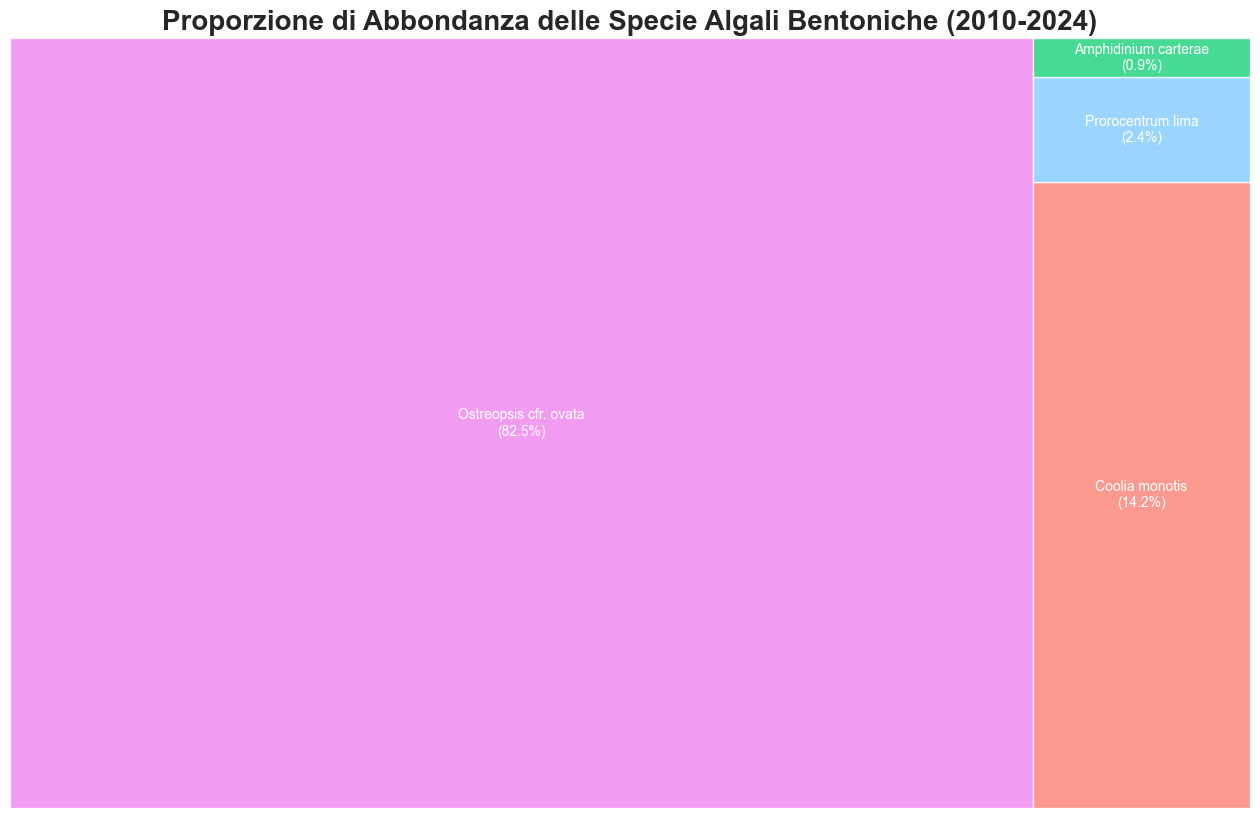

In [11]:
# treemap abbondanze bentoniche

# dizionario di colori e simboli per ogni specie
species_styles = {
    "Coolia monotis cell/gr": {"color": "salmon", "alpha": 0.7},
    "Amphidinium carterae cell/gr": {"color": "#18d17b", "alpha": 0.7},
    "Ostreopsis cfr. ovata cell/gr": {"color": "violet", "alpha": 0.7},
    "Prorocentrum lima cell/gr": {"color": "#82cafc", "alpha": 0.7},
}

tot_abundance_benthos = df[algae_bentonic].sum().sort_values(ascending=False)
cleaned_labels_benthos = tot_abundance_benthos.index.str.replace(
    " cell/gr", "", regex=False
)
tot_abundance_benthos.index = cleaned_labels_benthos

# preparazione dati per treemap
sizes = tot_abundance_benthos.values
# etichette con nome specie e abbondanza (in %)
total_sum = tot_abundance_benthos.sum()
labels = [
    f"{label}\n({(value/total_sum):.1%})"
    for label, value in tot_abundance_benthos.items()
]


plt.figure(figsize=(16, 10))
sns.set_theme(style="white")
color_map = {name.replace(" cell/gr", ""): style["color"] for name, style in species_styles.items()}
colors = [color_map.get(species, "lightgray") for species in tot_abundance_benthos.index]

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.8,
    text_kwargs={"fontsize": 10, "color": "white"},
)

plt.title(
    "Proporzione di Abbondanza delle Specie Algali Bentoniche (2010-2024)",
    fontsize=20,
    weight="bold",
)
plt.axis("off")  # rimuove assi
plt.show()

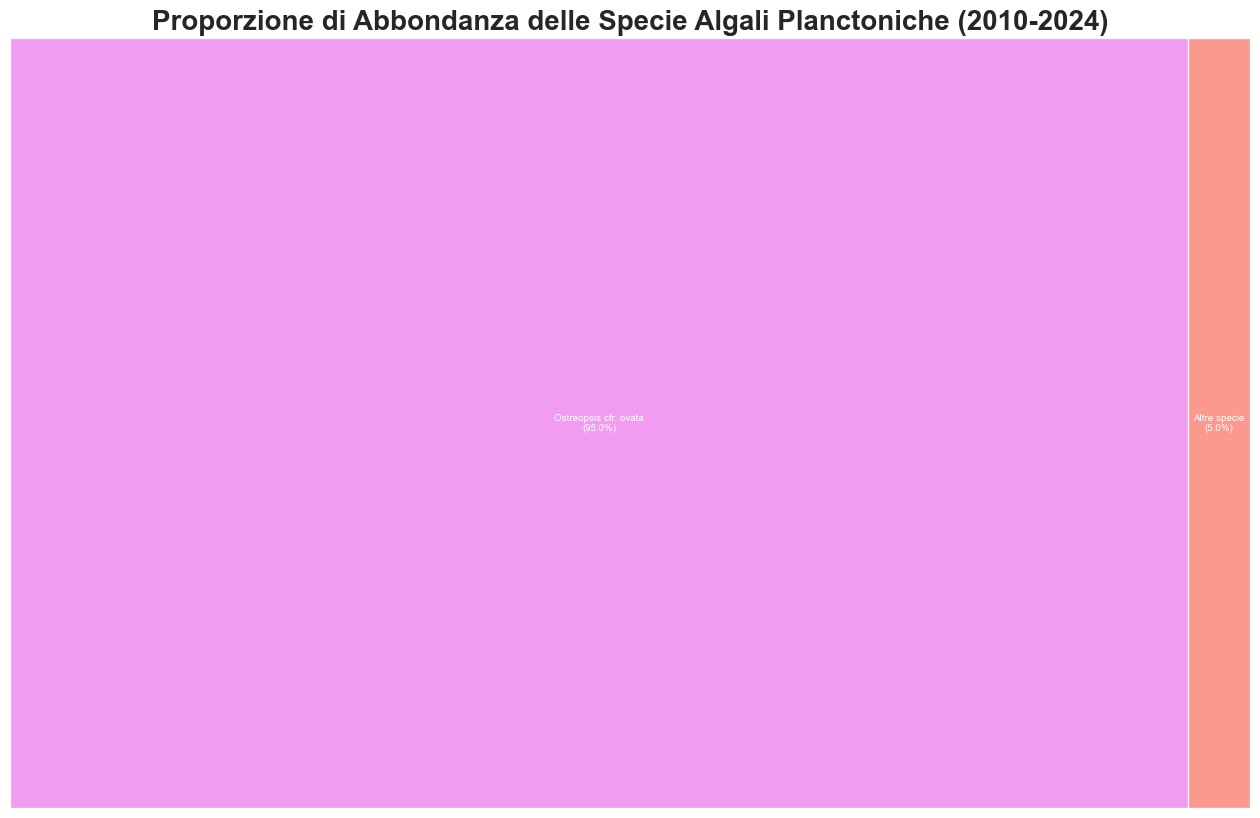

In [12]:
# treemap per abbondanze planctoniche

species_styles = {
    "Coolia monotis cell/l": {"color": "salmon", "alpha": 0.7},
    "Amphidinium carterae cell/l": {"color": "#18d17b", "alpha": 0.7},
    "Ostreopsis cfr. ovata cell/l": {"color": "violet", "alpha": 0.7},
    "Prorocentrum lima cell/l": {"color": "#82cafc", "alpha": 0.7}
}

tot_abundance_planctonic = df[algae_planctonic].sum().sort_values(ascending=False)

cleaned_labels_planctonic = tot_abundance_planctonic.index.str.replace(
    " cell/l", "", regex=False
)
tot_abundance_planctonic.index = cleaned_labels_planctonic

# imposto una soglia per migliore visualizzazione
total_sum = tot_abundance_planctonic.sum()
percentages = (tot_abundance_planctonic / total_sum) * 100
threshold = 3.0  # %
above_threshold = tot_abundance_planctonic[percentages >= threshold]
below_threshold = tot_abundance_planctonic[percentages < threshold]

if not below_threshold.empty:
    other_sum = pd.Series({"Altre specie": below_threshold.sum()})
    plot_data = pd.concat([above_threshold, other_sum])
    # mette insieme le specie sopra soglia con altre
else:
    plot_data = above_threshold

sizes = plot_data.values
total_for_labels = plot_data.sum()
labels = [
    f"{label}\n({(value/total_for_labels)*100:.1f}%)"
    for label, value in plot_data.items()
]


plt.figure(figsize=(16, 10))
sns.set_theme(style="white")
color_map = {name.replace(" cell/l", ""): style["color"] for name, style in species_styles.items()}
colors = [color_map.get(species, "lightgray") for species in tot_abundance_benthos.index]

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.8,
    text_kwargs={"fontsize": 7, "color": "white"},
)

plt.title(
    "Proporzione di Abbondanza delle Specie Algali Planctoniche (2010-2024)",
    fontsize=20,
    weight="bold",
)
plt.axis("off")
plt.show()

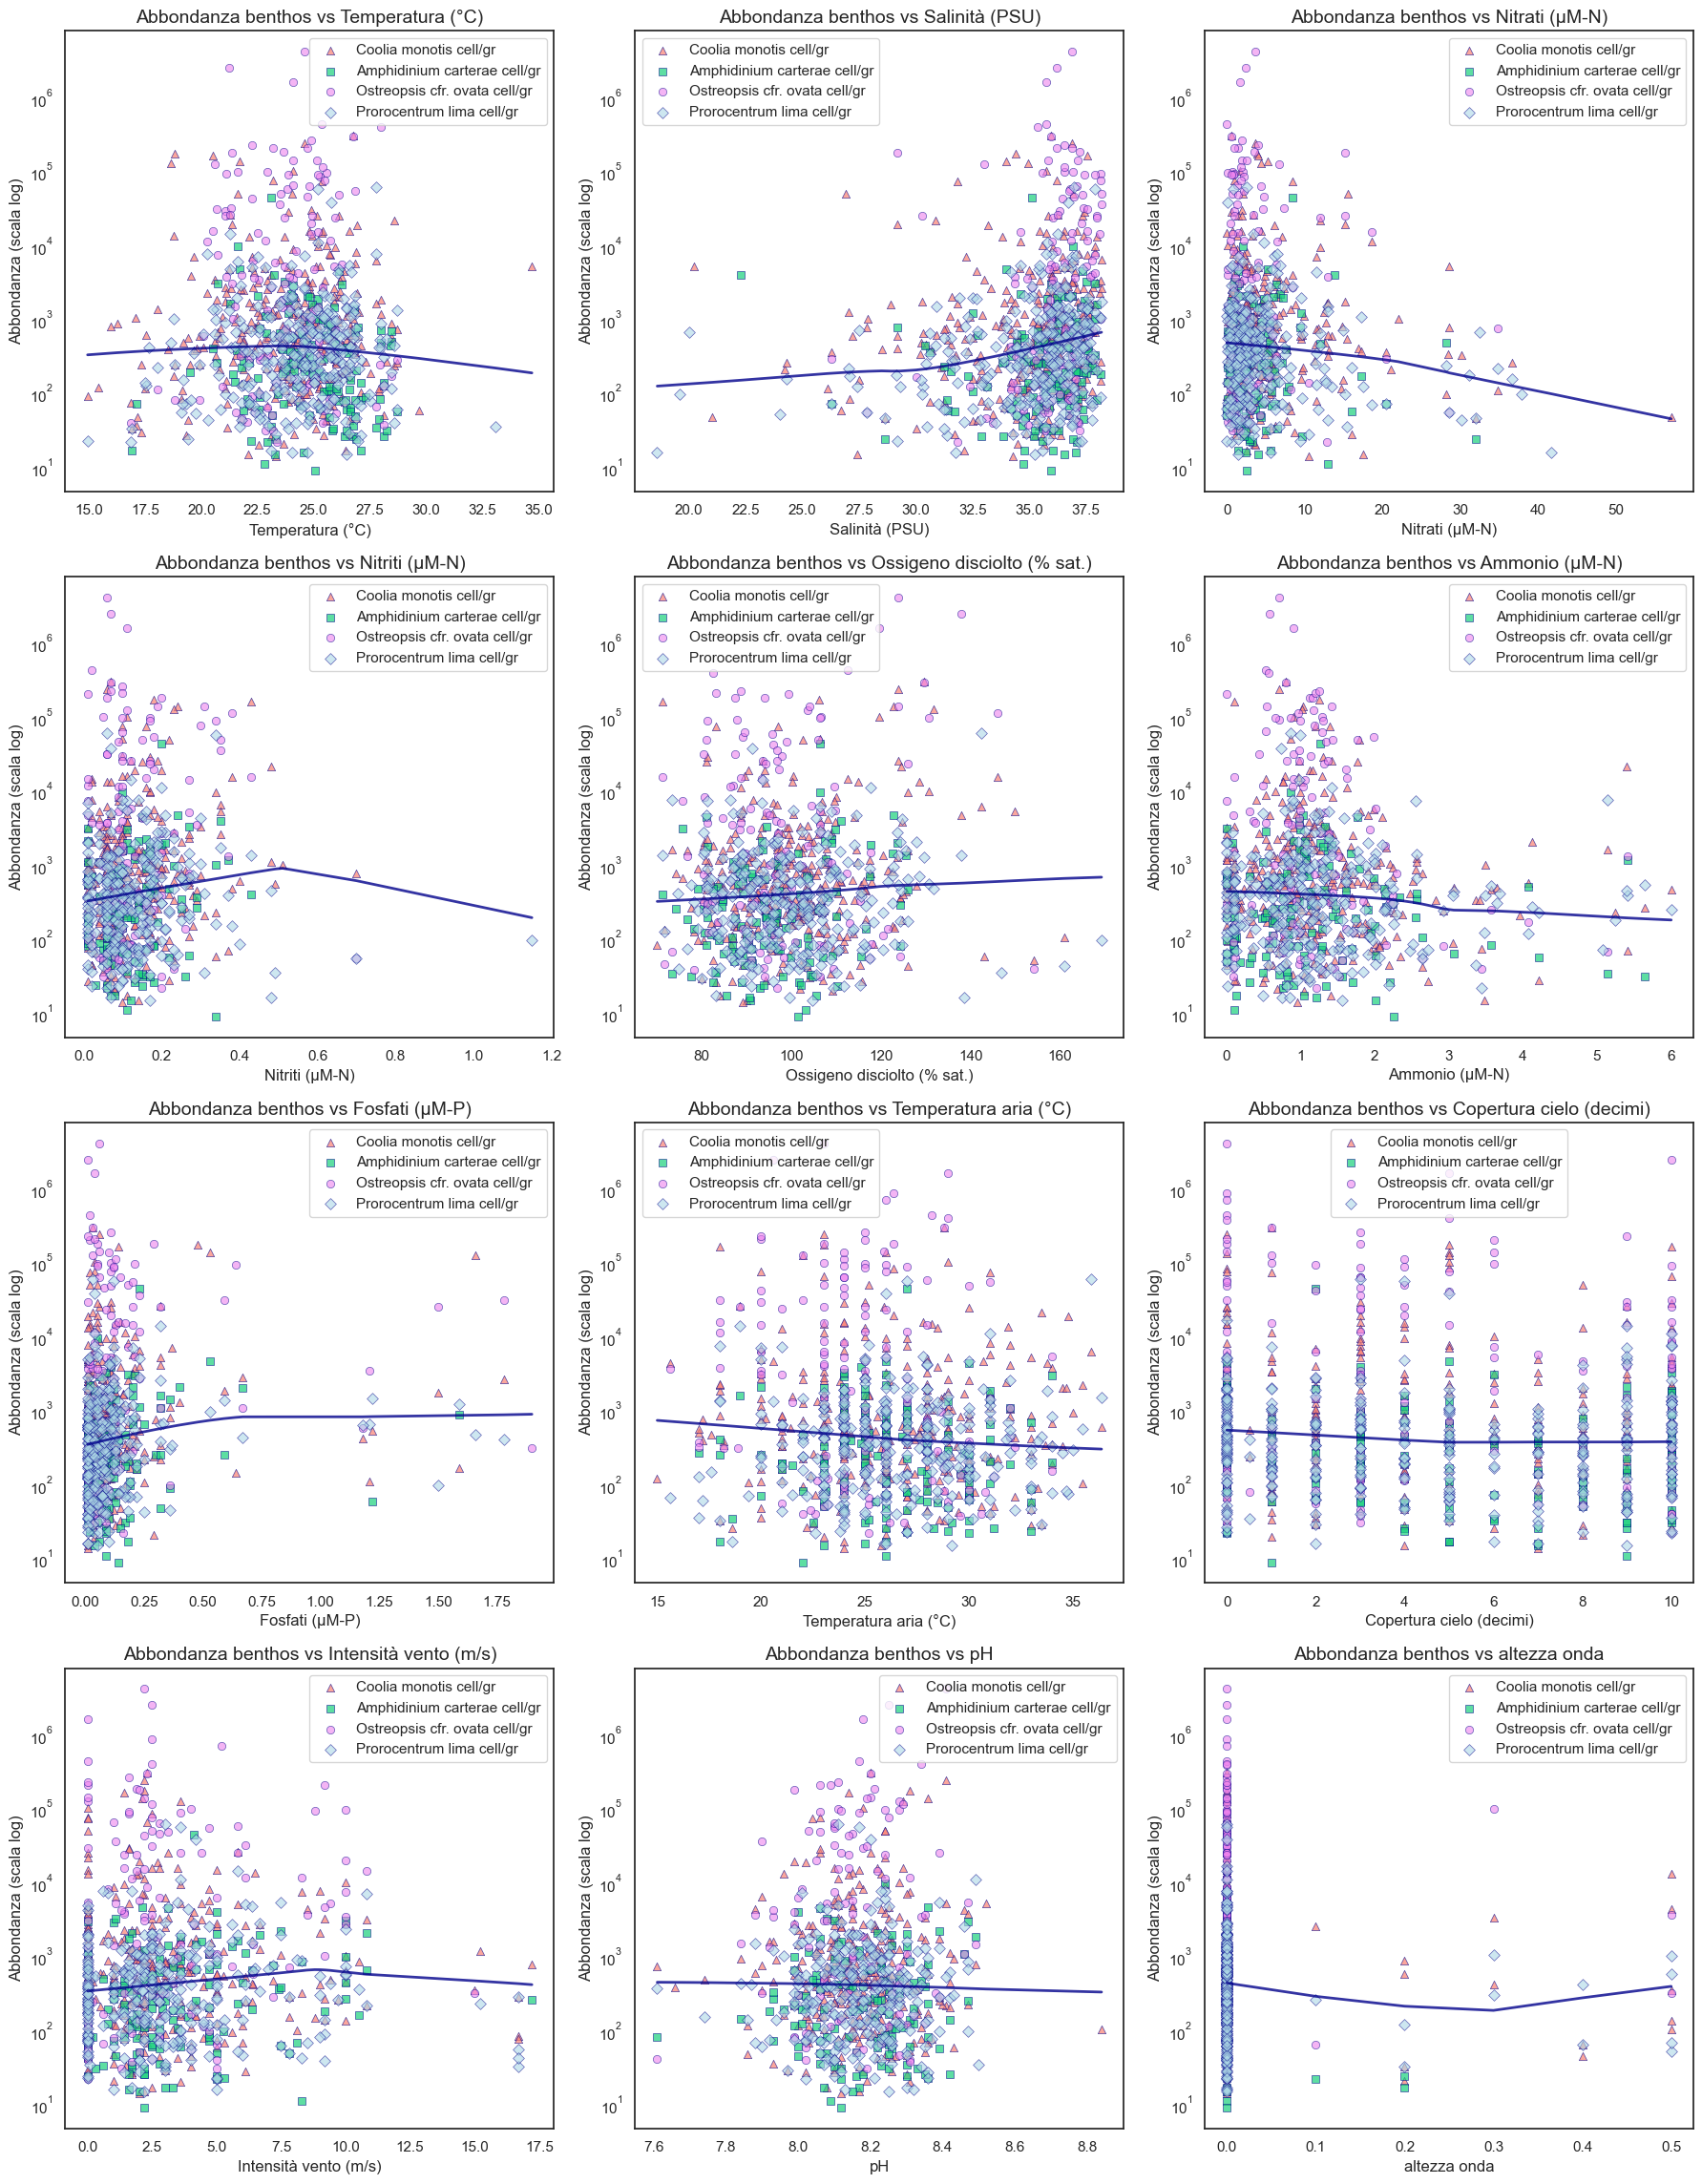

In [13]:
# colonne delle specie da plottare
species_to_plot = [
    "Coolia monotis cell/gr",
    "Amphidinium carterae cell/gr",
    "Ostreopsis cfr. ovata cell/gr",
    "Prorocentrum lima cell/gr",
]

# dizionario di colori e simboli per ogni specie
species_styles = {
    "Coolia monotis cell/gr": {"color": "salmon", "marker": "^", "alpha": 0.7},
    "Amphidinium carterae cell/gr": {
        "color": "#18d17b",
        "marker": "s",
        "alpha": 0.7,
    },
    "Ostreopsis cfr. ovata cell/gr": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima cell/gr": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}


n_vars = len(numeric_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))

axes = axes.flatten() if n_vars > 1 else [axes]

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    # Inizializza liste per contenere tutti i dati
    all_x_clean = []
    all_y_clean = []

    for species_name in species_to_plot:
        species_abundance = df[species_name]
        style = species_styles.get(
            species_name, {"color": "gray", "marker": "x", "alpha": 0.7}
        )

        mask = ~(
            pd.isna(df[var]) | pd.isna(species_abundance) | (species_abundance <= 0)
        )
        x_clean = df[var][mask]
        y_clean = species_abundance[mask]

        # Aggiungi i dati puliti alle liste aggregate
        all_x_clean.extend(x_clean)
        all_y_clean.extend(y_clean)

        # scatter plot con stili diversi
        sns.scatterplot(
            x=x_clean,
            y=y_clean,
            ax=ax,
            color=style["color"],
            marker=style["marker"],
            alpha=style["alpha"],
            edgecolor="darkblue",
            linewidth=0.5,
            label=species_name.split("_")[0],
        )  # etichetta per la legenda

    # Calcola e plotta una singola LOWESS per tutti i dati aggregati
    if len(all_x_clean) > 5:
        # Converti le liste in array numpy per il calcolo
        all_x_clean = np.array(all_x_clean)
        all_y_clean = np.array(all_y_clean)

        y_log = np.log10(all_y_clean)

        sort_idx = np.argsort(all_x_clean)
        x_sorted = all_x_clean[sort_idx]
        y_log_sorted = y_log[sort_idx]

        lowess_result = lowess(y_log_sorted, x_sorted, frac=1, return_sorted=True)
        x_smooth = lowess_result[:, 0]
        y_smooth_log = lowess_result[:, 1]
        y_smooth = 10**y_smooth_log

        ax.plot(
            x_smooth,
            y_smooth,
            "-",
            linewidth=2,
            alpha=0.8,
            color="darkblue",
        )

    ax.set_title(f"Abbondanza benthos vs {var}", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Abbondanza (scala log)")
    ax.set_xlabel(var)
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

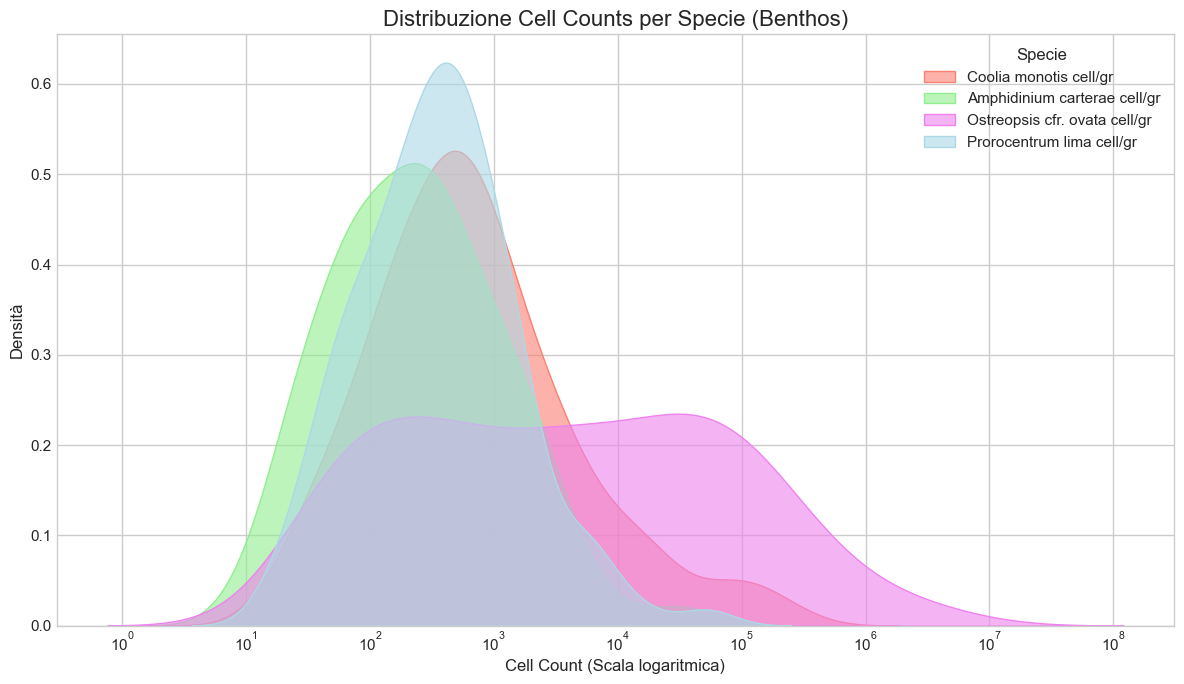

In [14]:
species_to_plot = [
    "Coolia monotis cell/gr",
    "Amphidinium carterae cell/gr",
    "Ostreopsis cfr. ovata cell/gr",
    "Prorocentrum lima cell/gr",
]

species_styles = {
    "Coolia monotis cell/gr": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    }, 
    "Amphidinium carterae cell/gr": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.6,
    },
    "Ostreopsis cfr. ovata cell/gr": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima cell/gr": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

for species_name in species_to_plot:
    style = species_styles.get(species_name, {"color": "gray", "alpha": 0.5})

    cell_counts = df[species_name].dropna()
    cell_counts = cell_counts[cell_counts > 0]

    if not cell_counts.empty:
        # KDE plot
        sns.kdeplot(
            data=cell_counts,
            ax=ax,
            color=style["color"],
            fill=True,
            alpha=style["alpha"],
            log_scale=True,
            label=species_name.split("_")[0],
        )


ax.set_title("Distribuzione Cell Counts per Specie (Benthos)", fontsize=16)
ax.set_xlabel("Cell Count (Scala logaritmica)", fontsize=12)
ax.set_ylabel("Densità", fontsize=12)

ax.legend(title="Specie")

plt.tight_layout()
plt.show()

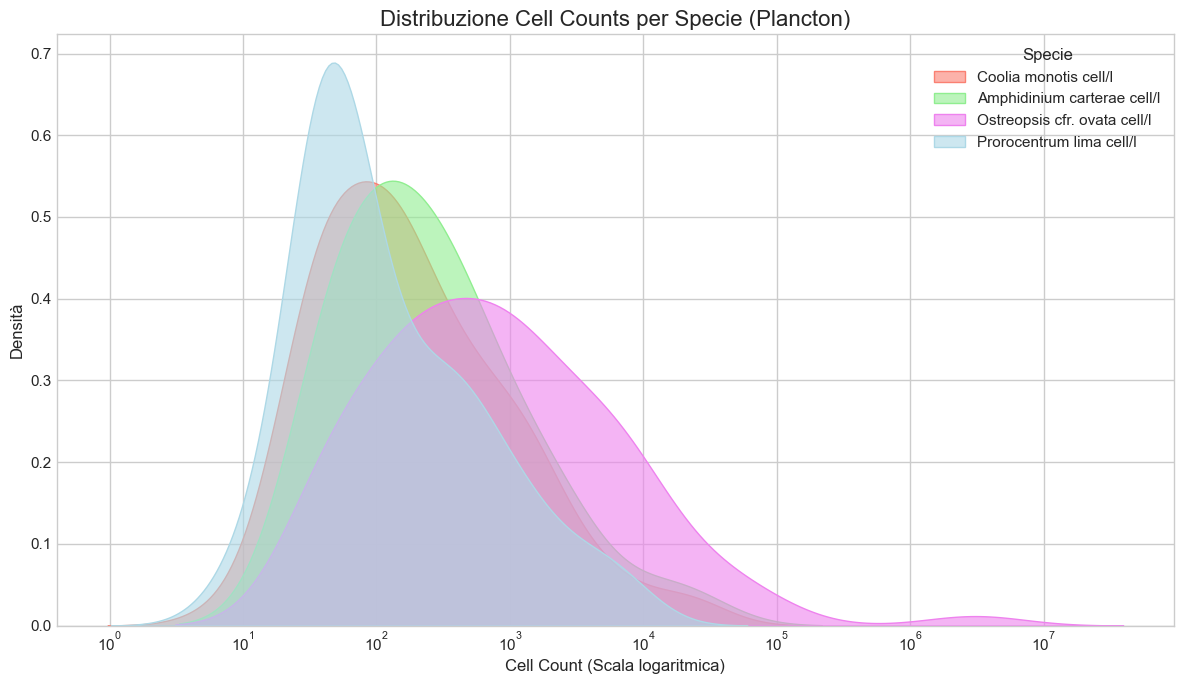

In [15]:
species_to_plot = [
    "Coolia monotis cell/l",
    "Amphidinium carterae cell/l",
    "Ostreopsis cfr. ovata cell/l",
    "Prorocentrum lima cell/l",
]

species_styles = {
    "Coolia monotis cell/l": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    },  
    "Amphidinium carterae cell/l": {"color": "lightgreen", "marker": "s", "alpha": 0.6},
    "Ostreopsis cfr. ovata cell/l": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima cell/l": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

for species_name in species_to_plot:
    style = species_styles.get(species_name, {"color": "gray", "alpha": 0.5})

    cell_counts = df[species_name].dropna()
    cell_counts = cell_counts[cell_counts > 0]

    if not cell_counts.empty:
        # KDE plot
        sns.kdeplot(
            data=cell_counts,
            ax=ax,
            color=style["color"],
            fill=True,
            alpha=style["alpha"],
            log_scale=True,
            label=species_name.split("_")[0],
        )


ax.set_title("Distribuzione Cell Counts per Specie (Plancton)", fontsize=16)
ax.set_xlabel("Cell Count (Scala logaritmica)", fontsize=12)
ax.set_ylabel("Densità", fontsize=12)

ax.legend(title="Specie")

plt.tight_layout()
plt.show()

In [16]:
month_map = {
    1: "gen",
    2: "feb",
    3: "mar",
    4: "apr",
    5: "mag",
    6: "giu",
    7: "lug",
    8: "ago",
    9: "set",
    10: "ott",
    11: "nov",
    12: "dic",
}

In [17]:
# identifichiamo le colonne con cell_gr
columns = [col for col in df.columns if "cell" in col]
df_stag = df.copy()

df_stag["MESE"] = df_stag["MESE"].map(month_map)


custom_colors = [
    "#FF6B6B",  # bright coral
    "#4ECDC4",  # bright teal
    "#45B7D1",  # bright blue
    "#96CEB4",  # pastel green
    "#FFEAA7",  # pastel yellow
    "#DDA0DD",  # pastel purple
    "#FFB347",  # pastel orange
    "#87CEEB",  # pastel sky blue
]

d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_a

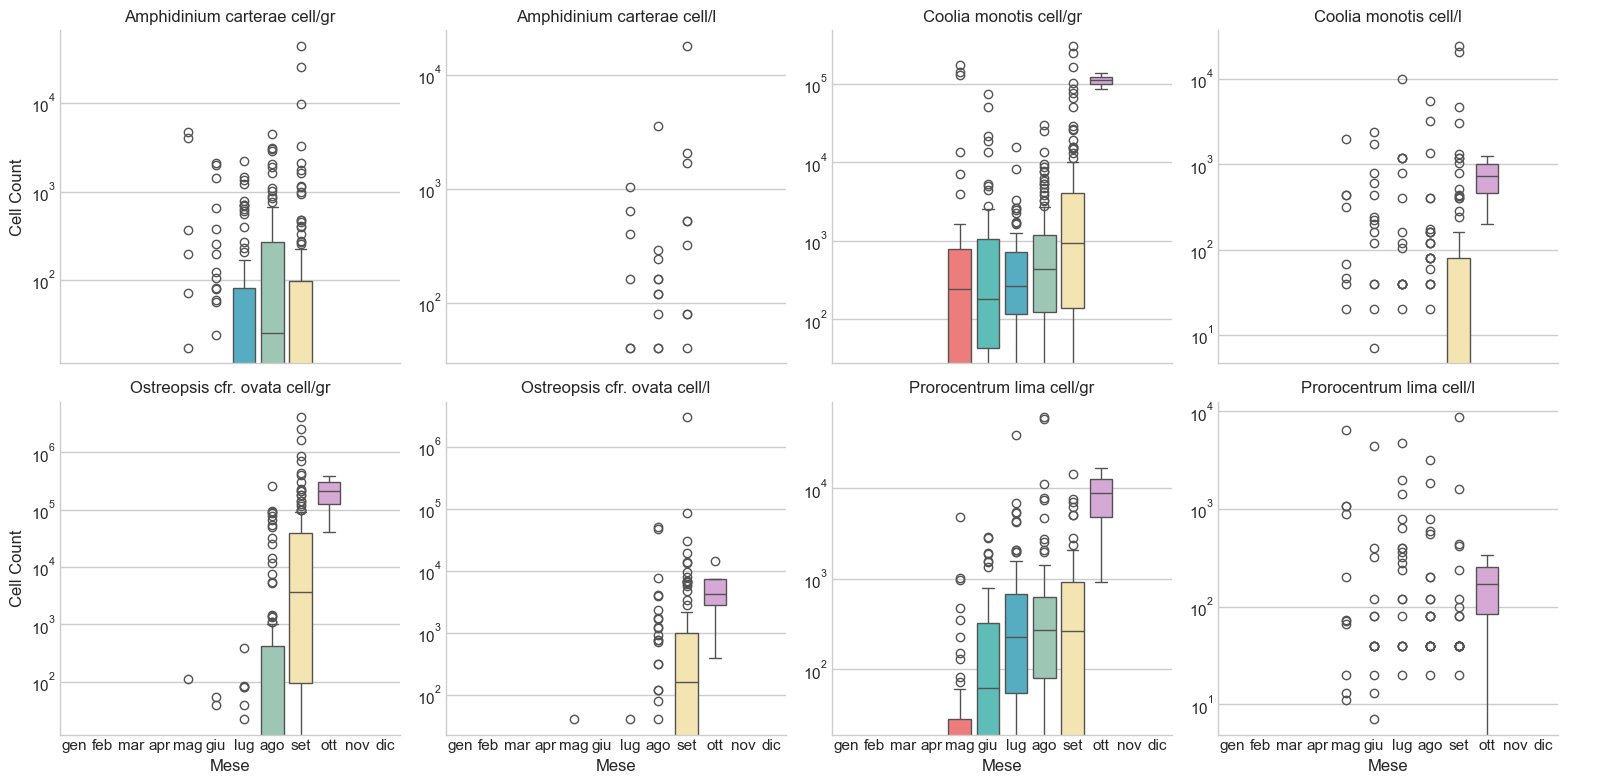

In [19]:
# riporto i dati nel long format
# seaborn lavora meglio con i dati in long format in questo caso
df_long = df_stag.melt(
    id_vars=["MESE"],
    value_vars=columns,
    var_name="Species",
    value_name="Cell Count",
)

g = sns.FacetGrid(df_long, col="Species", col_wrap=4, height=4, sharey=False)
g.map_dataframe(
    sns.boxplot,
    x="MESE",
    y="Cell Count",
    hue="MESE",
    order=list(month_map.values()),
    palette=custom_colors,
)
g.add_legend()
g.set_axis_labels("Mese", "Cell Count")
g.set_titles(col_template="{col_name}")
g.set(yscale="log")
g.tight_layout(w_pad=1)

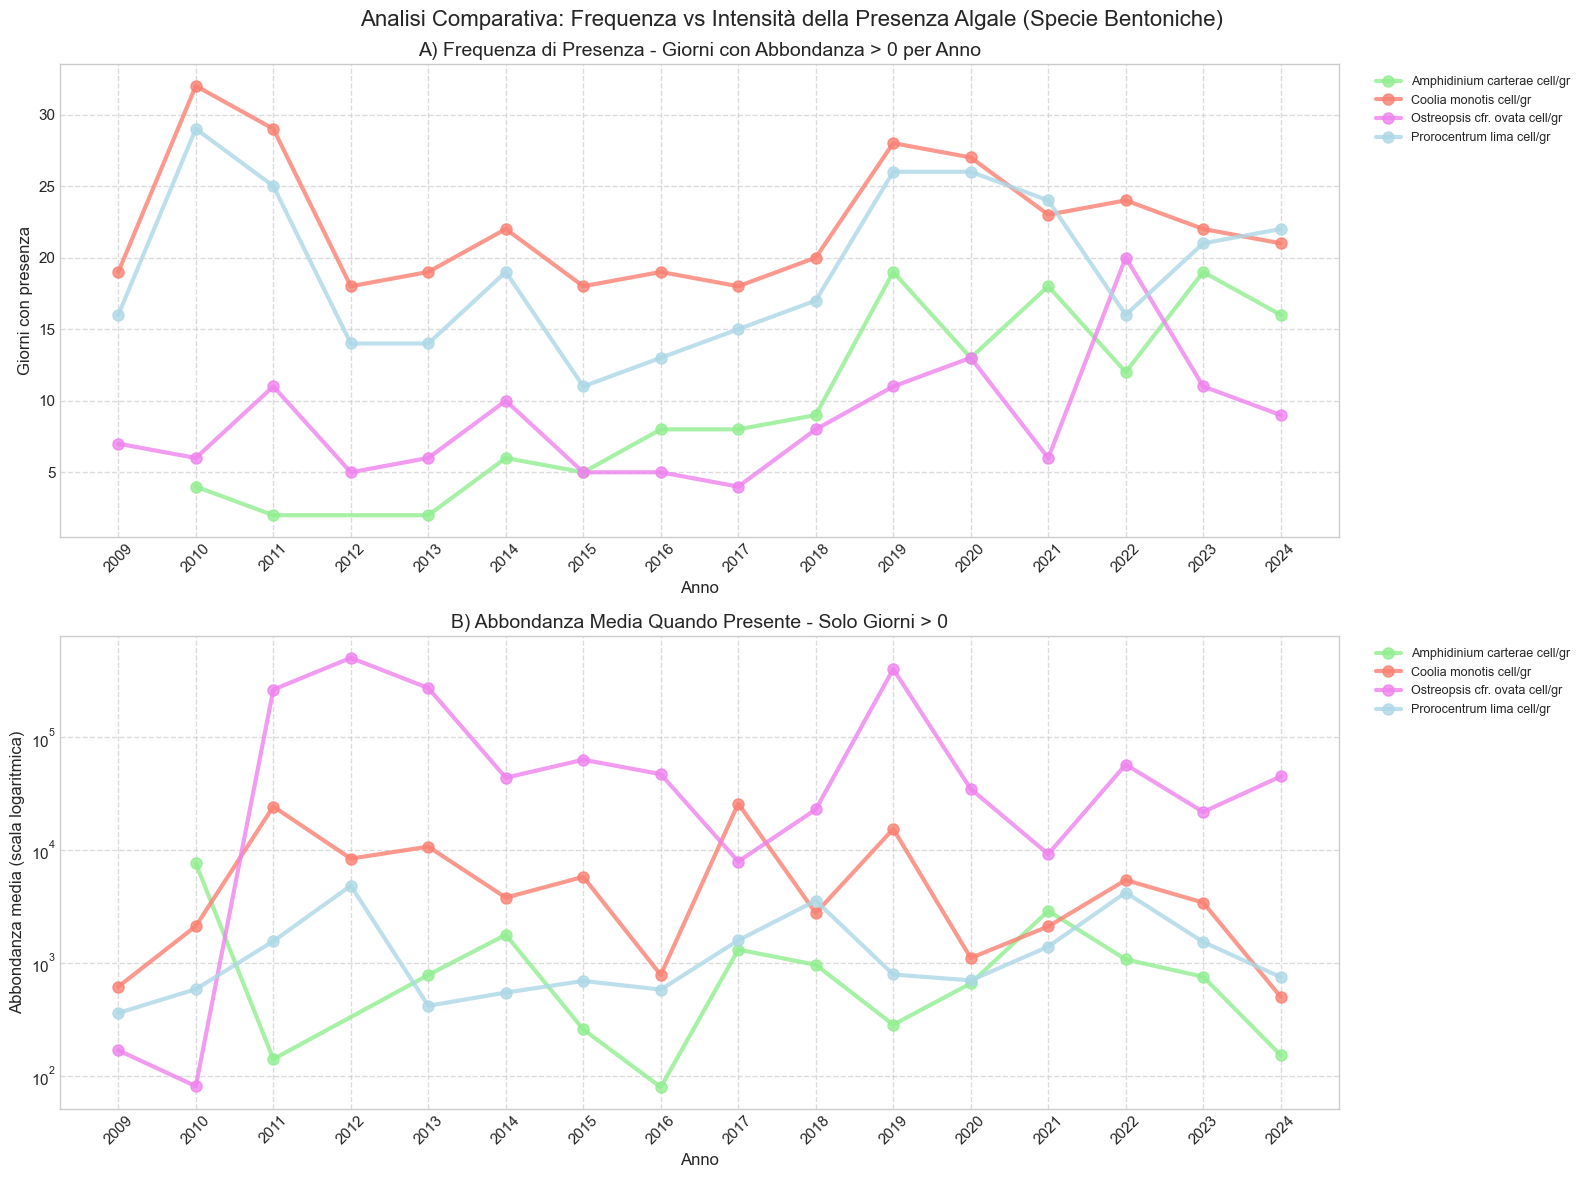

In [21]:
species_styles_b = {
    "Coolia monotis cell/gr": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    }, 
    "Amphidinium carterae cell/gr": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.6,
    },
    "Ostreopsis cfr. ovata cell/gr": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima cell/gr": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}

presence_data_bentonic = {}
abundance_when_present_bentonic = {}

for specie in algae_bentonic:
    # calcolo presenza
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data_bentonic[specie] = presence_by_year

    # calcolo abbondanza quando presente
    species_data = df[df[specie] > 0]
    if len(species_data) > 0:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present_bentonic[specie] = abundance_by_year

linewidth = 3
markersize = 8
alpha = 0.8

# grafico combinato
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1 subplot: frequenza di presenza
for i, specie in enumerate(algae_bentonic):
    if specie in presence_data_bentonic and len(presence_data_bentonic[specie]) > 0:
        
            style=species_styles_b[specie]
            ax1.plot(
            presence_data_bentonic[specie].index,
            presence_data_bentonic[specie].values,
            marker="o",
            label=specie,
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=style["color"],
            alpha=alpha,
        )

ax1.set_title(
    "A) Frequenza di Presenza - Giorni con Abbondanza > 0 per Anno", fontsize=14
)
ax1.set_xlabel("Anno", fontsize=12)
ax1.set_ylabel("Giorni con presenza", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

# 2 subplot: abbondanza quando presente
for i, specie in enumerate(algae_bentonic):
    if (
        specie in abundance_when_present_bentonic
        and len(abundance_when_present_bentonic[specie]) > 0
    ):
        
        style=species_styles_b[specie]
        ax2.plot(
            abundance_when_present_bentonic[specie].index,
            abundance_when_present_bentonic[specie].values,
            marker="o",
            label=specie,
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=style["color"],
            alpha=alpha,
        )

ax2.set_yscale("log")
ax2.set_title("B) Abbondanza Media Quando Presente - Solo Giorni > 0", fontsize=14)
ax2.set_xlabel("Anno", fontsize=12)
ax2.set_ylabel("Abbondanza media (scala logaritmica)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    ax1.set_xticks(anni_disponibili)
    ax1.tick_params(axis="x", rotation=45)
    ax2.set_xticks(anni_disponibili)
    ax2.tick_params(axis="x", rotation=45)

plt.suptitle(
    "Analisi Comparativa: Frequenza vs Intensità della Presenza Algale (Specie Bentoniche)",
    fontsize=16,
    y=0.98,
)
plt.tight_layout()
plt.show()

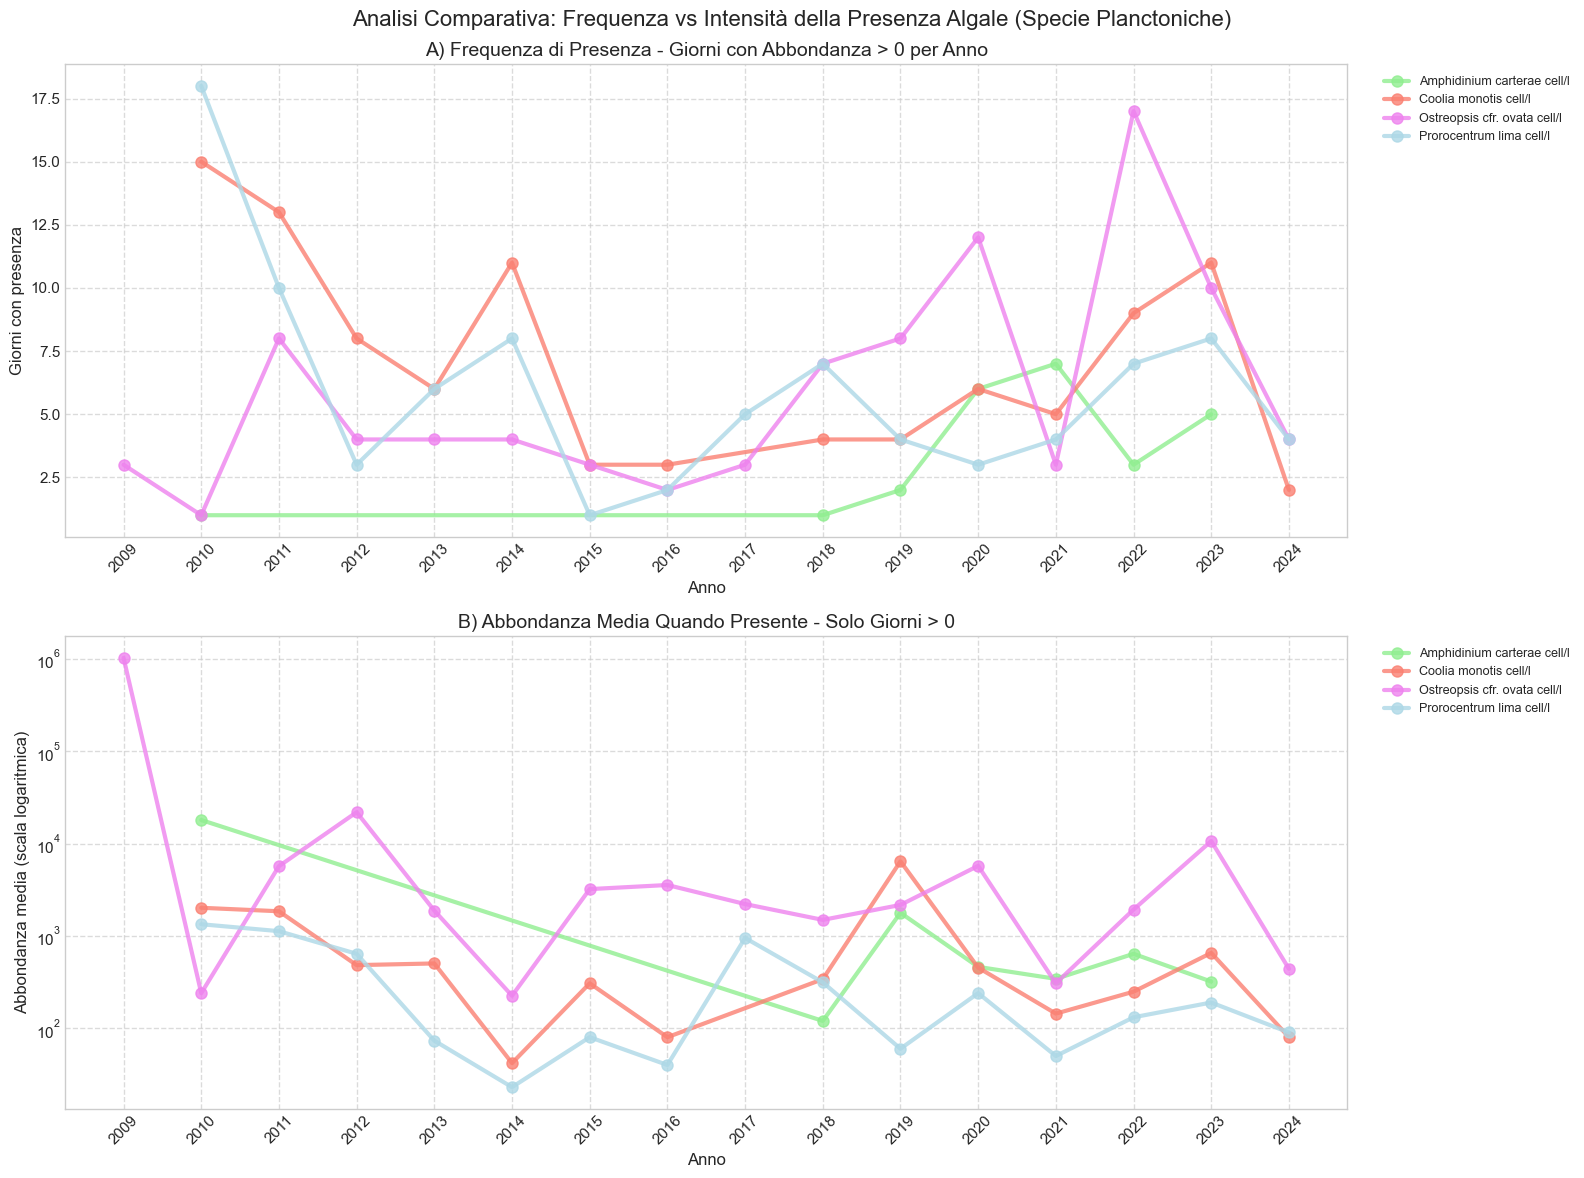

In [22]:
species_styles_p = {
    "Coolia monotis cell/l": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    }, 
    "Amphidinium carterae cell/l": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.6,
    },
    "Ostreopsis cfr. ovata cell/l": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima cell/l": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}

presence_data_planctonic = {}
abundance_when_present_planctonic = {}

for specie in algae_planctonic:
    # presenza per anno (giorni con abbondanza > 0)
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data_planctonic[specie] = presence_by_year 
    # abbondanza media quando presente
    species_data = df[df[specie] > 0][["ANNO", specie]]
    if not species_data.empty:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present_planctonic[specie] = abundance_by_year

linewidth = 3
markersize = 8
alpha = 0.8

# grafico combinato
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1 subplot: frequenza di presenza
for i, specie in enumerate(algae_planctonic):
    if specie in presence_data_planctonic and len(presence_data_planctonic[specie]) > 0:
        
            style=species_styles_p[specie]
            ax1.plot(
            presence_data_planctonic[specie].index,
            presence_data_planctonic[specie].values,
            marker="o",
            label=specie,
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=style["color"],
            alpha=alpha,
        )

ax1.set_title(
    "A) Frequenza di Presenza - Giorni con Abbondanza > 0 per Anno", fontsize=14
)
ax1.set_xlabel("Anno", fontsize=12)
ax1.set_ylabel("Giorni con presenza", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

# 2 subplot: abbondanza quando presente
for i, specie in enumerate(algae_planctonic):
    if (
        specie in abundance_when_present_planctonic
        and len(abundance_when_present_planctonic[specie]) > 0
    ):
        
        style=species_styles_p[specie]
        ax2.plot(
            abundance_when_present_planctonic[specie].index,
            abundance_when_present_planctonic[specie].values,
            marker="o",
            label=specie,
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=style["color"],
            alpha=alpha,
        )

ax2.set_yscale("log")
ax2.set_title("B) Abbondanza Media Quando Presente - Solo Giorni > 0", fontsize=14)
ax2.set_xlabel("Anno", fontsize=12)
ax2.set_ylabel("Abbondanza media (scala logaritmica)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    ax1.set_xticks(anni_disponibili)
    ax1.tick_params(axis="x", rotation=45)
    ax2.set_xticks(anni_disponibili)
    ax2.tick_params(axis="x", rotation=45)

plt.suptitle(
    "Analisi Comparativa: Frequenza vs Intensità della Presenza Algale (Specie Planctoniche)",
    fontsize=16,
    y=0.98,
)
plt.tight_layout()
plt.show()

C:\Users\39393\AppData\Local\Temp\ipykernel_16656\3982605876.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)
C:\Users\39393\AppData\Local\Temp\ipykernel_16656\3982605876.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["STAZIONE_LOCALITA"] = (


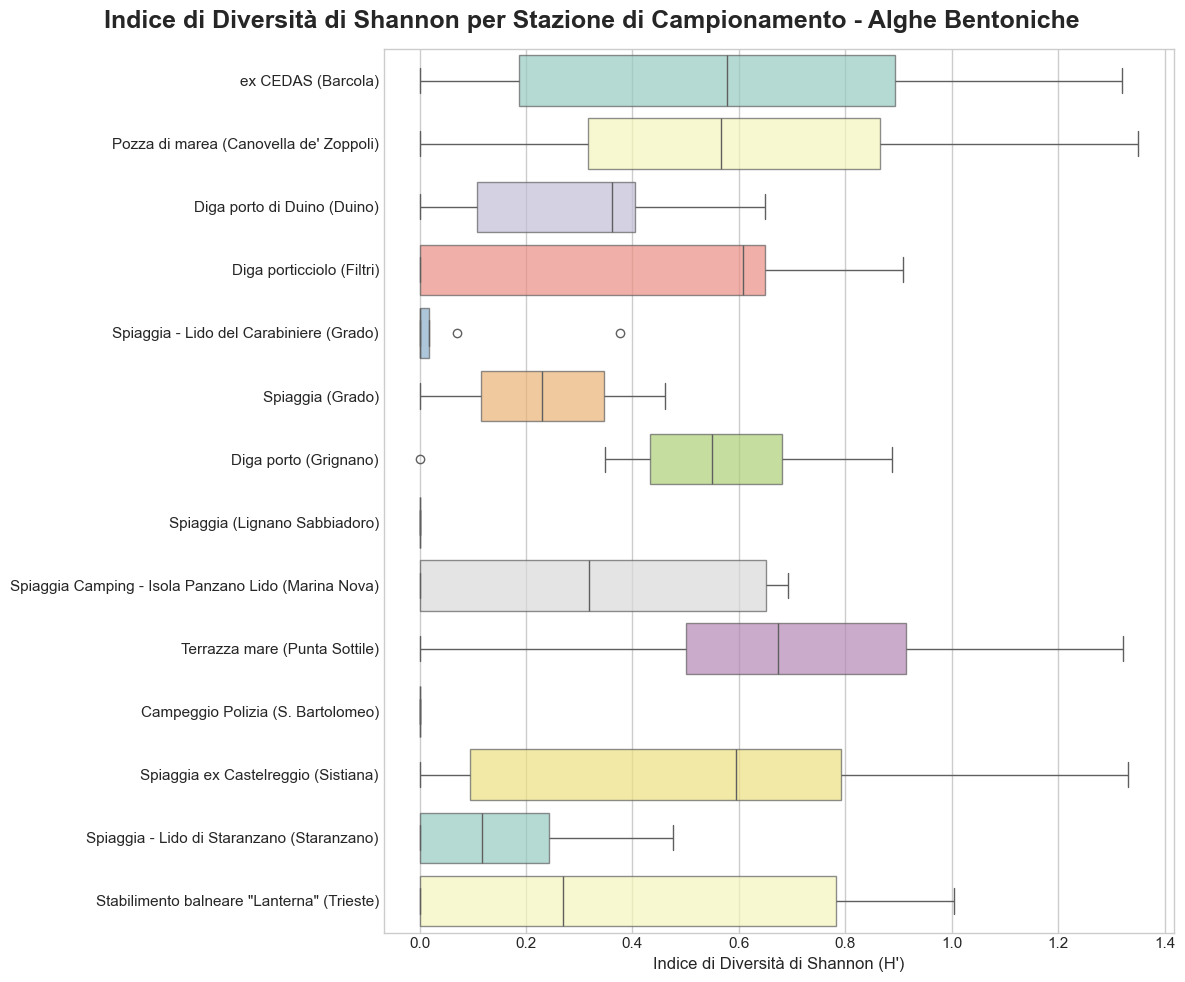

In [24]:
# calcolo shannon diversity index per sp bentoniche
def calculate_shannon(row):
    # calcolo counts colonna alghe bentoniche
    counts = row[algae_bentonic].copy()
    # rimuovo nan e tutti valori = 0
    counts = counts.dropna()
    counts = counts[counts > 0]

    if len(counts) > 0:
        # converto numpy array float altrimenti non fx con entropy
        counts_array = np.array(counts, dtype=float)
        return entropy(counts_array, base=math.e)
    return np.nan


# applico fx a ciascun campione
df["Shannon_Diversity"] = df.apply(calculate_shannon, axis=1)

# plot
# filtro per non avere nan
df_shannon_clean = df.dropna(subset=["Shannon_Diversity"])

df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)

sns.set_style("whitegrid")

# inserisco nome località nel grafico x maggiore chiarezza
localita_name = (
    df_shannon_clean["LOCALITA'"].astype(str).str.split("-").str[0].str.strip()
)

df_shannon_clean["STAZIONE_LOCALITA"] = (
    df_shannon_clean["STAZIONE"].astype(str) + " (" + localita_name + ")"
)

# inverto gli assi per avere una migliore leggibilità
# 3. Shannon Diversity per stazione con assi invertiti
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=df_shannon_clean,
    x="Shannon_Diversity",
    y="STAZIONE_LOCALITA",
    hue="STAZIONE_LOCALITA",
    palette="Set3",
    boxprops={"alpha": 0.7},
)
plt.suptitle(
    "Indice di Diversità di Shannon per Stazione di Campionamento - Alghe Bentoniche",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.ylabel("")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

C:\Users\39393\AppData\Local\Temp\ipykernel_16656\4126868774.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)
C:\Users\39393\AppData\Local\Temp\ipykernel_16656\4126868774.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["STAZIONE_LOCALITA"] = (
C:\Users\39393\AppData\Local\Temp\ipykernel_16656\4126868774.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an un

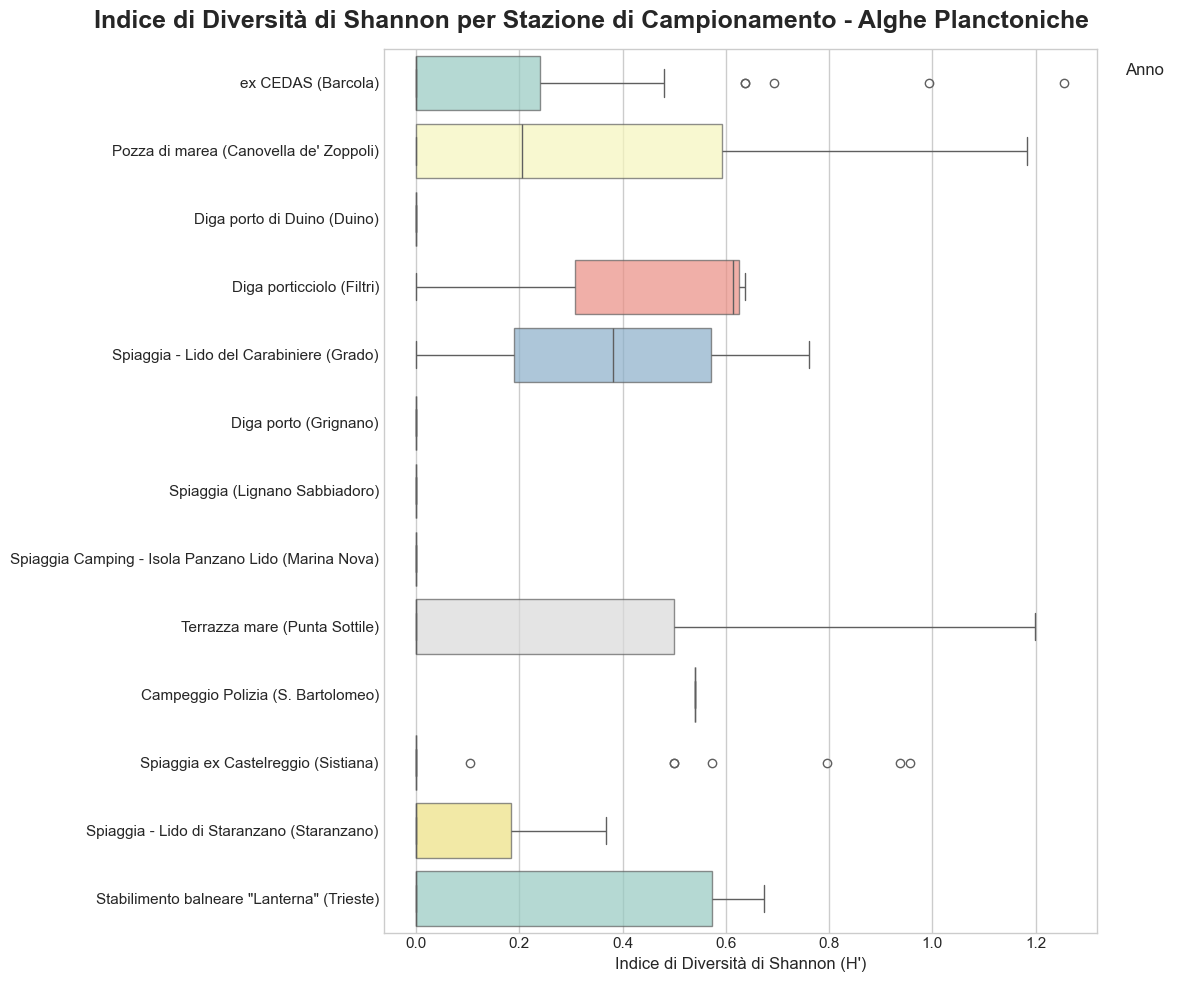

In [26]:
# calcolo shannon diversity index per sp planctoniche
def calculate_shannon(row):
    # calcolo counts colonna alghe planctoniche
    counts = row[algae_planctonic].copy()
    # rimuovo nan e tutti valori = 0
    counts = counts.dropna()
    counts = counts[counts > 0]

    if len(counts) > 0:
        # converto numpy array float altrimenti non fx con entropy
        counts_array = np.array(counts, dtype=float)
        return entropy(counts_array, base=math.e)
    return np.nan


# applico fx a ciascun campione
df["Shannon_Diversity"] = df.apply(calculate_shannon, axis=1)

# plot
# filtro per non avere nan
df_shannon_clean = df.dropna(subset=["Shannon_Diversity"])

df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)

sns.set_style("whitegrid")

# inserisco nome località nel grafico x maggiore chiarezza
localita_name = (
    df_shannon_clean["LOCALITA'"].astype(str).str.split("-").str[0].str.strip()
)

df_shannon_clean["STAZIONE_LOCALITA"] = (
    df_shannon_clean["STAZIONE"].astype(str) + " (" + localita_name + ")"
)

# inverto gli assi per avere una migliore leggibilità
# 3. Shannon Diversity per stazione con assi invertiti
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=df_shannon_clean,
    x="Shannon_Diversity",
    y="STAZIONE_LOCALITA",
    hue="STAZIONE_LOCALITA",
    palette="Set3",
    boxprops={"alpha": 0.7},
)
plt.suptitle(
    "Indice di Diversità di Shannon per Stazione di Campionamento - Alghe Planctoniche",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.ylabel("")
plt.legend(title="Anno", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()